## Original Description
> Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.
>
> The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.
>
> While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!
>
> To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.
>
> Help save them and change history!

### Features
- `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
- `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- `Destination` - The planet the passenger will be debarking to.
- `Age` - The age of the passenger.
- `VIP` - Whether the passenger has paid for special VIP service during the voyage.
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- `Name` - The first and last names of the passenger.

### Labels
- `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [19]:
%matplotlib inline

In [20]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import json
from sklearn import manifold

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder, LabelEncoder

import xgboost as xgb
import lightgbm as lgb

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, HalvingGridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix

import eli5
from eli5.sklearn import PermutationImportance

from xgboost import plot_tree

warnings.filterwarnings('ignore')

In [21]:
try:
    df = pd.read_csv('../input/spaceship-titanic/train.csv')
    # df_test = pd.read_csv('../input/spaceship-titanic/test.csv')
except FileNotFoundError:
    df = pd.read_csv('spaceship-titanic/train.csv')
    # df_test = pd.read_csv('/spaceship-titanic/test.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [22]:
def preprocess(data,preTrain = True):
    # drop the entire cols that have low to now interest for now
    df = data.drop(['Name','PassengerId'],axis = 1)
    if preTrain:
        df = df.dropna()

    target = df['Transported']
    target = target.astype(int)

    # Split the cabins
    df['Cabin_splt'] = df['Cabin'].apply(lambda x : str(x).split(sep = '/'))

    df['Cabin_1']= df['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
    df['Cabin_2']= df['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[1]).astype('float')
    df['Cabin_3']= df['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[2])

    df = df.drop(['Cabin','Cabin_splt'],axis=1)

    numeric_cols = list(df.select_dtypes(include = np.number).columns)
    print(f"Numeric columns ({len(numeric_cols)}) :", ", ".join(numeric_cols))

    category_cols = list(df.select_dtypes(include = ['object']).columns)
    print(f"Categorical columns ({len(category_cols)}) :", ", ".join(category_cols))

    # processing categorical null value
    for col in category_cols:
    #         print(f"{col} mode : {all_data[col].mode()[0]}")
        df[col] = df[col].fillna(df[col].mode()[0])

    # processing numerical null value
    for col in numeric_cols:
        # using the mode
        df[col] = df[col].fillna(df[col].mode()[0])

    df_n=df[numeric_cols]
    df_c=df[category_cols]

    # label encode
    enc = LabelEncoder()
    for col in category_cols:  
        df_c[col] = enc.fit_transform(df_c[col])

    for col in ['HomePlanet', 'Destination']:
        df_c[f'{col}_count_encoding'] = df_c[col].map(df_c[col].value_counts())
        df_c[col] = df_c[col].replace(-1, np.nan)

    for column in df_c:
        df_n[f"cat_{column}"] = df_c[column]

    df_n['Total'] = sum(df[col] for col in numeric_cols if col not in ["Age", "Cabin_2"])

    # Categorize the Total Spending 0.43
    df_n['Spend_Category'] = ''
    df_n.loc[df_n['Total'].between(0, 1, 'left'), 'Spend_Category'] = 'Zero_Spend'
    df_n.loc[df_n['Total'].between(1, 500, 'both'), 'Spend_Category'] = 'Under_500'
    df_n.loc[df_n['Total'].between(500, 1000, 'right'), 'Spend_Category'] = 'Under_1k'
    df_n.loc[df_n['Total'].between(1000, 1500, 'right'), 'Spend_Category'] = 'Under_1.5k'
    df_n.loc[df_n['Total'].between(1500, 2000, 'right'), 'Spend_Category'] = 'Under_2k'
    df_n.loc[df_n['Total'].between(2000, 2500, 'right'), 'Spend_Category'] = 'Under_2.5k'
    df_n.loc[df_n['Total'].between(2500, 3000, 'right'), 'Spend_Category'] = 'Under_3k'
    df_n.loc[df_n['Total'].between(3000, 10000, 'right'), 'Spend_Category'] = 'Under_10k'
    df_n['Spend_Category'] = df_n['Spend_Category'].astype('category').cat.codes.astype("int") 


    # Dividing in intervals of 10 gave a correlation of -0.09 to Transported, diving into 4 categories gave a -0.12
    df_n['Age_Category'] = ''
    df_n.loc[df_n['Age'].between(0, 18, 'both'), 'Age_Category'] = 'Under_18'
    df_n.loc[df_n['Age'].between(18, 40, 'right'), 'Age_Category'] = 'Adult'
    df_n.loc[df_n['Age'].between(40, 60, 'right'), 'Age_Category'] = 'Middle_Age'
    df_n.loc[df_n['Age'].between(60, 100, 'right'), 'Age_Category'] = 'Over_60'
    df_n['Age_Category'] = df_n['Age_Category'].astype('category').cat.codes.astype("int")   
    return df_n, target

In [23]:
# initiate the traning and test datasets--for trainning
df_n, target = preprocess(df)
X_train, X_test, y_train, y_test = train_test_split(df_n, target, test_size = 0.2, 
                                                    random_state = 100, stratify=target)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Numeric columns (7) : Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, Cabin_2
Categorical columns (6) : HomePlanet, CryoSleep, Destination, VIP, Cabin_1, Cabin_3
(5411, 18) (1353, 18) (5411,) (1353,)


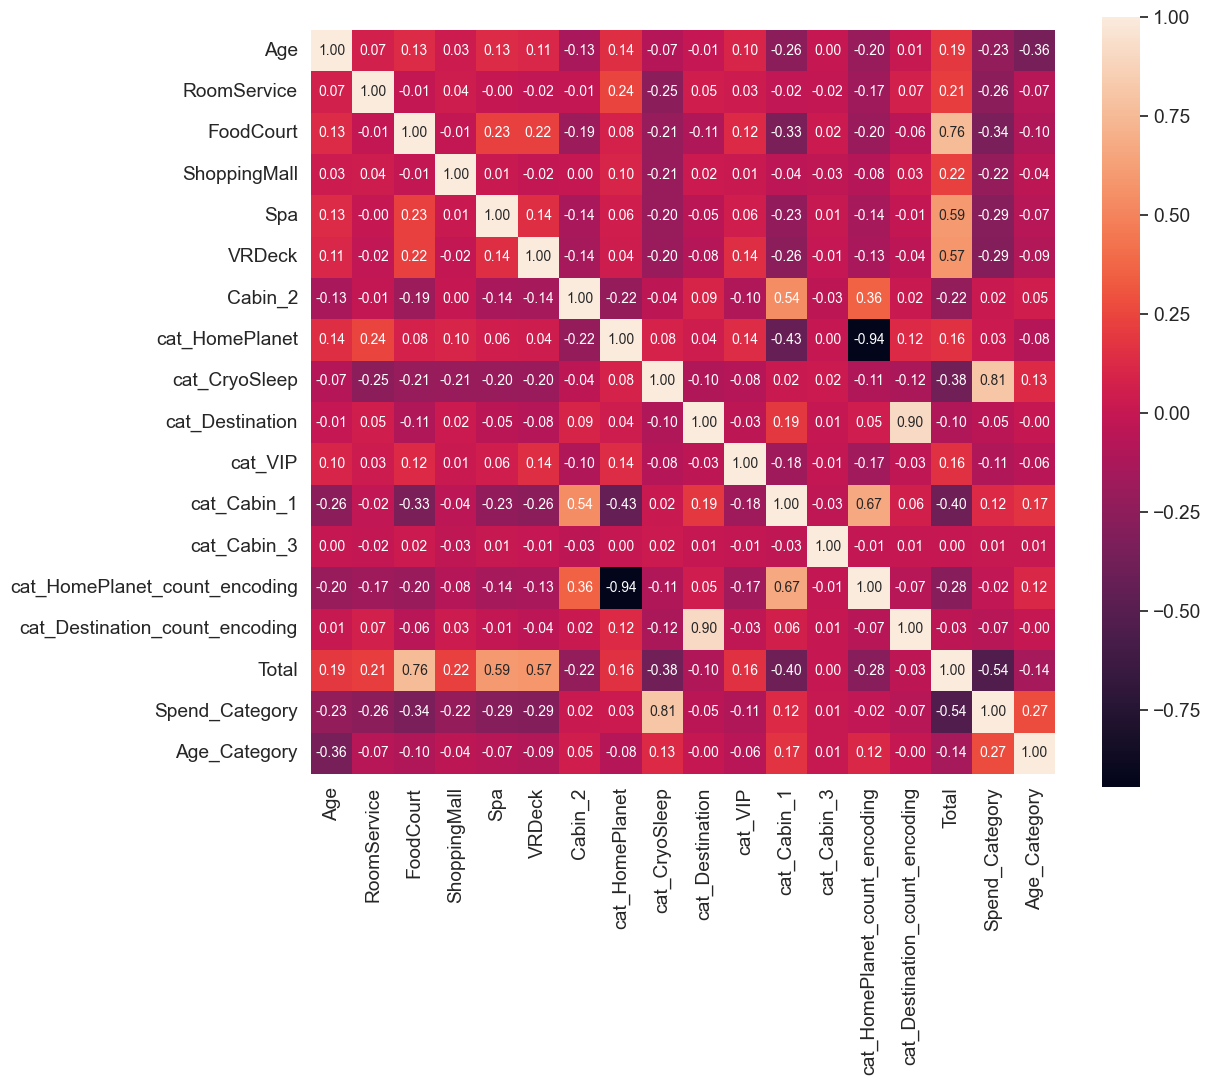

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Cabin_2', 'cat_HomePlanet', 'cat_CryoSleep', 'cat_Destination',
       'cat_VIP', 'cat_Cabin_1', 'cat_Cabin_3',
       'cat_HomePlanet_count_encoding', 'cat_Destination_count_encoding',
       'Total', 'Spend_Category', 'Age_Category'],
      dtype='object')


In [24]:
# T_train = X_train
# T_train["Transported"] = y_train

f,ax = plt.subplots(figsize=(12, 10))
cols = X_train.corr().abs().index
cm = np.corrcoef(X_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()
# cols = cols.drop('Transported')
print(cols)

In [25]:
# PARAMETERS={"objective":'binary:logistic',"eval_metric":"auc","max_depth":6,
#             "min_child_weight":0,"gamma":1,"subsample": 0.75, "colsample_bytree": 0.8, "scale_pos_weight": 1,
#             "reg_alpha": 0.159,"reg_lambda":1, "learning_rate":0.266}
PARAMETERS = {'booster' : ['gbtree'],
              'gamma': [5,],
              'eta': [0.05],
              'learning_rate': [0.05,],
              "subsample": [1,], 
              'max_depth': [3,],
              'n_estimators': [600,],
              "colsample_bytree": [0.5,],
              "scale_pos_weight": [1,],
              'reg_alpha': [0,],
              'reg_lambda': [2,],}

# GridSearchCV
# grid_search_xgb = GridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic",
#                                                            eval_metric="auc"),verbose = 1,
#                                                            param_grid=PARAMETERS,cv = 3,scoring='accuracy',
#                                                            n_jobs=-1).fit(X_train.values, y_train.values.ravel())

# HalvingGridSearchCV
grid_search_xgb = HalvingGridSearchCV(estimator=xgb.XGBClassifier(objective="binary:logistic",
                                                           eval_metric="auc"),param_grid=PARAMETERS,verbose = 1,
                                                           cv = 4,scoring='accuracy',max_resources=1000,random_state = 0,
                                                           resource='n_samples',n_jobs=-1).fit(X_train.values, y_train.values.ravel())

xgbr_best = grid_search_xgb.best_estimator_

print('xgbr_best Best Score',grid_search_xgb.best_score_)
print('xgbr_best Best Parmas',grid_search_xgb.best_params_)
print('xgbr_best Accuracy',cross_val_score(xgbr_best,X_train.values, y_train.values.ravel(), cv=3).mean())
# print('xgbr feature importances',grid_search_xgb.feature_importances_)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 1000
max_resources_: 1000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 1000
Fitting 4 folds for each of 1 candidates, totalling 4 fits
xgbr_best Best Score 0.7787550200803214
xgbr_best Best Parmas {'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta': 0.05, 'gamma': 5, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 600, 'reg_alpha': 0, 'reg_lambda': 2, 'scale_pos_weight': 1, 'subsample': 1}
xgbr_best Accuracy 0.8002218934608042


In [26]:
perm = PermutationImportance(grid_search_xgb, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0387 ± 0.0109,Spa
0.0307 ± 0.0124,FoodCourt
0.0266 ± 0.0075,VRDeck
0.0210 ± 0.0055,RoomService
0.0152 ± 0.0058,ShoppingMall
0.0137 ± 0.0079,cat_CryoSleep
0.0108 ± 0.0097,Cabin_2
0.0105 ± 0.0057,cat_Cabin_1
0.0099 ± 0.0088,Total
0.0071 ± 0.0089,cat_Cabin_3


              precision    recall  f1-score   support

           0       0.81      0.77      0.79       673
           1       0.79      0.82      0.80       680

    accuracy                           0.80      1353
   macro avg       0.80      0.80      0.80      1353
weighted avg       0.80      0.80      0.80      1353



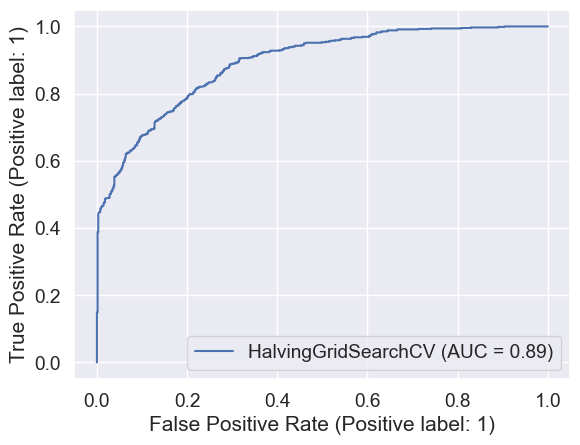

In [27]:
pred = grid_search_xgb.predict(X_test)
print(classification_report(y_test, pred, target_names=["0","1"]))
plot_roc_curve(grid_search_xgb, X_test, y_test)

In [28]:
#----------------For submission----------------
data1= pd.read_csv("spaceship-titanic/train.csv")
data2 = pd.read_csv("spaceship-titanic/test.csv")
data2['Transported'] =-1
dataT = pd.concat([data1,data2],axis = 0,ignore_index=True)

df_T,target = preprocess(dataT,preTrain = False)
X_testT = df_T[df_T['Transported'] ==-1]
X_testT = X_testT.drop(['Transported'],axis = 1)

pred = grid_search_xgb.predict(X_testT)
pred = pred.astype(bool)

result=pd.read_csv('spaceship-titanic/sample_submission.csv')
result['Transported'] = pred
result.to_csv('submission.csv', index=False)

Numeric columns (8) : Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, Transported, Cabin_2
Categorical columns (6) : HomePlanet, CryoSleep, Destination, VIP, Cabin_1, Cabin_3
